In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import jax, optax
from jax import random, numpy as jnp
from flax import linen as nn
from flax.training import train_state
from flax.core.frozen_dict import freeze, unfreeze

!git clone https://github.com/htymjun/da-sr
os.chdir('/content/da-sr')

from read import fw_to_np

Cloning into 'da-sr'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 43 (delta 19), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (43/43), 10.01 MiB | 19.38 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [2]:
# read cn and fw files
u, v, w, p, t, icount, x, y, z = fw_to_np('data')
# interpolate
uc = 0.5e0*(u[:-1,:,:]+u[1:,:,:])
vc = 0.5e0*(v[:,:-1,:]+v[:,1:,:])
wc = 0.5e0*(w[:,:,:-1]+w[:,:,1:])
xc = 0.5e0*(x[:-1]+x[1:])
yc = 0.5e0*(y[:-1]+y[1:])
zc = 0.5e0*(z[:-1]+z[1:])

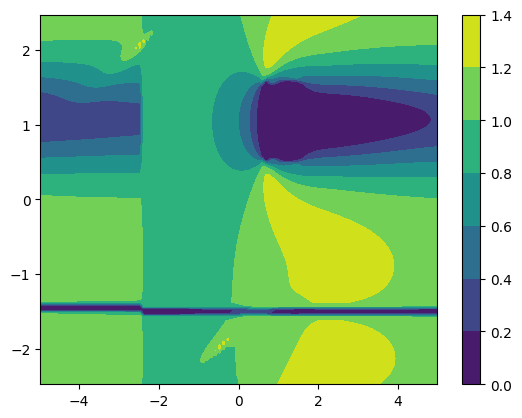

In [3]:
Nz = int(0.5*len(zc))
U = np.sqrt(uc[:,:,Nz]**2+vc[:,:,Nz]**2)
Xc, Yc = np.meshgrid(xc,yc)

fig, ax = plt.subplots()
tcf = ax.contourf(Xc, Yc, np.transpose(U))
fig.colorbar(tcf)

In [4]:
# set_batch
Nx = 5
Ny = 5
ub = uc[:,:,Nz].reshape(-1,5,5)
vb = vc[:,:,Nz].reshape(-1,5,5)
x = np.stack([ub,vb], axis=-1)

# normalize
N = len(x[:,0,0,0])
ave = np.zeros(N)
for i in range(N):
  ave[i] = 0.5e0*(x[i,:,:,0].mean()+x[i,:,:,1].mean())
  x[i,:,:,0] = np.divide(x[i,:,:,0],ave[i])
  x[i,:,:,1] = np.divide(x[i,:,:,1],ave[i])

In [107]:
class GCNN(nn.Module):
  filters: jnp.ndarray

  @nn.compact
  def __call__(self, x):
    # Z2-P4 conv
    x1 = nn.Conv(features=jnp.rot90(self.filters, k=1, axes=(0,1)).shape[-1], kernel_size=(3,3), strides=(1, 1), padding='SAME')(x)
    x2 = nn.Conv(features=jnp.rot90(self.filters, k=2, axes=(0,1)).shape[-1], kernel_size=(3,3), strides=(1, 1), padding='SAME')(x)
    x3 = nn.Conv(features=jnp.rot90(self.filters, k=3, axes=(0,1)).shape[-1], kernel_size=(3,3), strides=(1, 1), padding='SAME')(x)
    x4 = nn.Conv(features=jnp.rot90(self.filters, k=4, axes=(0,1)).shape[-1], kernel_size=(3,3), strides=(1, 1), padding='SAME')(x)
    # P4-P4 conv

    # max pooling
    x1 = nn.max_pool(x1, window_shape=(2,2), strides=(2,2), padding='SAME')
    x2 = nn.max_pool(x2, window_shape=(2,2), strides=(2,2), padding='SAME')
    x3 = nn.max_pool(x3, window_shape=(2,2), strides=(2,2), padding='SAME')
    x4 = nn.max_pool(x4, window_shape=(2,2), strides=(2,2), padding='SAME')

    x = jnp.maximum(x1,x2)
    x = jnp.maximum(x,x3)
    x = jnp.maximum(x,x4)
    return x

In [115]:
# initialize model
key = random.PRNGKey(0)
filter_shape = (5,5,2)  # filter_shape(height,width,input_channels,output_channels)
filters = random.normal(key, shape=filter_shape)
model = GCNN(filters)

params = model.init(key, jnp.ones_like(x[:,:,:,:])) # x(batch,height,width,channel)

# calc convolution
output1 = model.apply(params,np.rot90(x, axes=(1,2)))

# initialize filters
filters = random.normal(key, shape=filter_shape)
model = GCNN(filters)

# initialize parameter
params = model.init(key, jnp.ones_like(x)) # x (batch,height,width,channel)

# calc convolution
output2 = np.rot90(model.apply(params,x), axes=(1,2))

[Text(0, 0.0, ''),
 Text(0, 0.2, ''),
 Text(0, 0.4, ''),
 Text(0, 0.6000000000000001, ''),
 Text(0, 0.8, ''),
 Text(0, 1.0, '')]

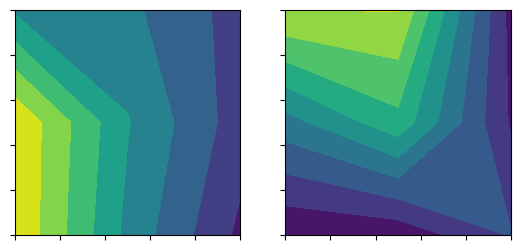

In [116]:
# visualize
Xc, Yc = np.meshgrid(np.linspace(0,1,3),np.linspace(0,1,3))

fig, axes = plt.subplots(1,2)
tcf = axes[0].contourf(Xc, Yc, output1[0,:,:,0])
axes[0].set_aspect('equal')
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
tcf = axes[1].contourf(Xc, Yc, output2[0,:,:,0])
axes[1].set_aspect('equal')
axes[1].set_xticklabels([])
axes[1].set_yticklabels([])